In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size+hidden_size,hidden_size)
        self.T = nn.Tanh()

    def forward(self, input_data, hidden):
        A = self.W.forward(torch.cat([input_data,hidden],1))
        hidden = self.T(A)
        return hidden

    def init_hidden(self,batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=3

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([3, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.29889157 -0.2717526   0.19512768 -0.4985185   0.04524643]
 [ 0.5091424  -0.29833162  0.00409273 -0.55591375  0.202631  ]
 [ 0.29075027 -0.20476004  0.15622436 -0.4620644   0.07025383]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.20944685 -0.28358486  0.28809604 -0.50481653 -0.1184712 ]
 [ 0.40492687 -0.32267284  0.09607754 -0.59119415  0.03830349]
 [ 0.21215498 -0.21051574  0.22895446 -0.4758424  -0.07062721]]


In [ ]:
!mkdir data

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 4 root root 4.0K Dec 28 20:50 MNIST


Populating the interactive namespace from numpy and matplotlib


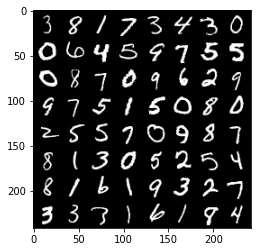

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs)

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0538,  0.0955,  0.0176, -0.0149,  0.0690, -0.0339,  0.0106,  0.0784,
          0.1041, -0.0267],
        [-0.0447,  0.1030,  0.0244, -0.0169,  0.0686, -0.0263,  0.0035,  0.0794,
          0.0970, -0.0261],
        [-0.0353,  0.1009,  0.0120, -0.0175,  0.0644, -0.0289,  0.0115,  0.0822,
          0.1151, -0.0369],
        [-0.0457,  0.0997,  0.0203, -0.0251,  0.0687, -0.0339,  0.0098,  0.0857,
          0.1049, -0.0295],
        [-0.0472,  0.0980,  0.0181, -0.0213,  0.0696, -0.0360,  0.0106,  0.0835,
          0.1031, -0.0278],
        [-0.0502,  0.1003,  0.0176, -0.0233,  0.0695, -0.0339,  0.0091,  0.0783,
          0.0994, -0.0280],
        [-0.0482,  0.1013,  0.0172, -0.0233,  0.0697, -0.0364,  0.0122,  0.0815,
          0.0992, -0.0246],
        [-0.0735,  0.1069,  0.0531, -0.0187,  0.0674, -0.0271,  0.0095,  0.0833,
          0.1108, -0.0357],
        [-0.0203,  0.1045, -0.0441, -0.0360,  0.0671, -0.0485,  0.0019,  0.0857,
          0.0941, -0.0358],
        [-0.0381,  

## Обучаем

In [ ]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs) 
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 95.93


In [ ]:
!pip install torchtext
!python -m spacy download en

In [ ]:
import torch
import torch.optim as optim
from torchtext import data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy',include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['Yesterday', ',', 'I', 'went', 'to', 'the', 'monthly', 'Antique', 'Flea', 'Market', 'that', 'comes', 'to', 'town', '.', 'I', 'really', 'have', 'no', 'interest', 'in', 'such', 'things', ',', 'but', 'I', 'went', 'for', 'the', 'fellowship', 'of', 'friends', 'who', 'do', 'have', 'such', 'an', 'interest', '.', 'Looking', 'over', 'the', 'hundreds', 'of', 'vendor', ',', 'passing', 'many', 'of', 'them', 'quickly', ',', 'I', 'spotted', 'someone', 'selling', 'VHS', 'tapes', 'and', 'DVDs', '.', 'Most', 'of', 'the', 'films', 'he', 'had', 'on', 'DVD', 'were', 'rather', 'recent', ';', 'the', 'oldest', 'one', 'I', 'noticed', 'was', 'the', '1940', 'Cary', 'Grant', '-', 'Irene', 'Dunne', 'co', '-', 'starrer', 'MY', 'FAVORITE', 'WIFE', '.', 'But', 'the', 'VHS', 'tapes', ',', 'by', 'their', 'nature', ',', 'were', 'mostly', 'older', 'films', '.', 'I', 'could', "n't", 'resist', 'buying', 'SOMETHING', 'since', 'they', 'were', 'being', 'sold', 'at', '3', 'tapes', 'for', '$', '10.00', '.', 'What', '

In [ ]:

import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:

TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(<function torchtext.vocab._default_unk_index>,
             {'neg': 0, 'pos': 1}),
 'vectors': None}

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202671), (',', 193179), ('.', 166120), ('and', 109869), ('a', 109605), ('of', 100769), ('to', 94160), ('is', 76590), ('in', 61330), ('I', 54246), ('it', 53421), ('that', 49290), ('"', 44711), ("'s", 43316), ('this', 42479), ('-', 37164), ('/><br', 35900), ('was', 34911), ('as', 30256), ('movie', 29908)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f09465de730>, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split = data.BucketIterator.splits((train_data, valid_data, test_data),batch_size=BATCH_SIZE,
                                    sort_within_batch=True,sort_key = lambda batch : len(batch.text),
                                    device=device) 

In [ ]:
train_iterator, valid_iterator, test_iterator = split


In [ ]:

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim,output_dim)
    

    def forward(self,text, text_len):

        embedded = self.embedding(text)
        comp_output, hidden = self.rnn(pack_padded_sequence(embedded,text_len))
        output, output_len = pad_packed_sequence(comp_output)
        
        return self.fc(hidden.squeeze(0))

In [ ]:
vocab = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 256
output = 1
model = RNN(vocab, embedding_dim, hidden_dim, output)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)


In [ ]:
import numpy as np

def scoring(y_pred, y):
    y_pred = torch.round(torch.sigmoid(y_pred)) 
    return torch.mean((y_pred == y).float())

def train(model, iter, optim, criterion):
    
    epoch_loss,epoch_acc = [0,0]
    model.train()
    
    for batch in iter:
        optim.zero_grad()

        text, text_len = batch.text
            
        y_pred = model(text, text_len).squeeze(1)
        y_true =  batch.label
        
        loss = criterion(y_pred, y_true)
        acc = scoring(y_pred, y_true)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iter), epoch_acc / len(iter)



In [ ]:

epoch = 4

for _ in range(epoch):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

    print(f'| Epoch: {_+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')